In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as image

import time
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    print("Warning: CUDA not found. Using CPU")

In [3]:
class OasisDataset(Dataset):
    """
        Custom PyTorch dataset for loading OASIS images and labels.

    Attributes (Where N - batch, C - channels, D - depth, H - height, W - width):
        images (torch.Tensor): Image tensors of shape (N, C, H, W).
        labels (torch.Tensor): Label tensors of shape (N, H, W, C) or (N, H, W).
    """
    def __init__(self, images, labels):
        # Convert to torch tensors and ensure channels-first format
        self.images = torch.from_numpy(images).permute(0, 3, 1, 2)  # (N, H, W, 1) → (N, 1, H, W)
        self.labels = torch.from_numpy(labels)  # (N, H, W, C) or (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
def load_training(path):
    """
    Load training images from the specified directory.
    """
    image_list = []
    for filename in glob.glob(path + "/*.png"):
        im = image.imread(filename)
        image_list.append(im)
    print("train_X shape:", np.array(image_list).shape)
    return np.array(image_list, dtype=np.float32)

def process_training(data_set):
    """
    Normalise and reshape training images.
    """
    data_set = data_set.astype(np.float32)
    if data_set.max() > 1.0:
        data_set = data_set / 255.0
    data_set = data_set[:, :, :, np.newaxis]  # (N, H, W, 1)
    return data_set

def load_labels(path):
    """
    Load label masks and map pixel values to integer class IDs.
    """
    image_list = []
    for filename in glob.glob(path + "/*.png"):
        im = image.imread(filename)
        one_hot = np.zeros((im.shape[0], im.shape[1]))
        for i, unique_value in enumerate(np.unique(im)):
            one_hot[:, :][im == unique_value] = i
        image_list.append(one_hot)
    print("train_y shape:", np.array(image_list).shape)
    return np.array(image_list, dtype=np.uint8)

def process_labels(seg_data):
    """
    Convert integer label masks into one-hot encoded format.
    """
    onehot_Y = []
    for n in range(seg_data.shape[0]):
        im = seg_data[n]
        n_classes = 4
        one_hot = np.zeros((im.shape[0], im.shape[1], n_classes), dtype=np.uint8)
        for i, unique_value in enumerate(np.unique(im)):
            one_hot[:, :, i][im == unique_value] = 1
        onehot_Y.append(one_hot)
    onehot_Y = np.array(onehot_Y)
    print("Labels shape:", onehot_Y.shape)
    return onehot_Y

In [4]:
train_X = process_training(load_training("oasis/keras_png_slices_data/keras_png_slices_train"))
train_Y = process_labels(load_labels("oasis/keras_png_slices_data/keras_png_slices_seg_train"))
train_dataset = OasisDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_X = process_training(load_training("oasis/keras_png_slices_data/keras_png_slices_test"))
test_Y = process_labels(load_labels("oasis/keras_png_slices_data/keras_png_slices_seg_test"))
test_dataset = OasisDataset(test_X, test_Y)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_X shape: (9664, 256, 256)
train_y shape: (9664, 256, 256)
Labels shape: (9664, 256, 256, 4)
train_X shape: (544, 256, 256)
train_y shape: (544, 256, 256)
Labels shape: (544, 256, 256, 4)


In [5]:
class DoubleConv(nn.Module):
    """
    A two-layer convolutional block used in UNet.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

In [6]:
class UNet(nn.Module):
    """
    UNet with encoder channel sizes similar to the provided VAE (1 -> 32 -> 64 -> 128 -> 256 -> 512).
    The decoder mirrors the encoder and uses transposed convolutions for upsampling.
    Final layer outputs n_classes channels (categorical / one-hot style output before Softmax).
    """
    def __init__(self, n_classes: int = 4, input_channels: int = 1, base_filters: int = 32):
        super().__init__()
        f = base_filters
        # Encoder
        self.inc = DoubleConv(input_channels, f)                            # 1 -> 32
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f, f*2))     # 32 -> 64
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*2, f*4))   # 64 -> 128
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*4, f*8))   # 128 -> 256
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*8, f*16))  # 256 -> 512

        # Decoder
        self.up1 = nn.ConvTranspose2d(f*16, f*8, kernel_size=2, stride=2)   # 512 -> 256
        self.dec1 = DoubleConv(f*16, f*8)

        self.up2 = nn.ConvTranspose2d(f*8, f*4, kernel_size=2, stride=2)    # 256 -> 128
        self.dec2 = DoubleConv(f*8, f*4)

        self.up3 = nn.ConvTranspose2d(f*4, f*2, kernel_size=2, stride=2)    # 128 -> 64
        self.dec3 = DoubleConv(f*4, f*2)

        self.up4 = nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2)      # 64 -> 32
        self.dec4 = DoubleConv(f*2, f)

        # Final conv to produce logits for each class
        self.outc = nn.Conv2d(f, n_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        x1 = self.inc(x)     # (N,   f,    H, W)
        x2 = self.down1(x1)  # (N,  2f,  H/2, W/2)
        x3 = self.down2(x2)  # (N,  4f,  H/4, W/4)
        x4 = self.down3(x3)  # (N,  8f,  H/8, W/8)
        x5 = self.down4(x4)  # (N, 16f, H/16, W/16)

        # Decoder with skip connections
        d1 = self.up1(x5)
        d1 = torch.cat([d1, x4], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, x3], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat([d4, x1], dim=1)
        d4 = self.dec4(d4)

        logits = self.outc(d4)  # (N, n_classes, H, W)
        return logits

In [7]:
def soft_dice_score(pred_softmax: torch.Tensor, target_onehot: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Compute Dice score per class and return mean across classes.
    pred_softmax : (N, C, H, W) probabilities after softmax
    target_onehot: (N, H, W, C) or (N, C, H, W) one-hot target (expects float / 0/1)
    Returns mean Dice across classes (averaged over batch and classes).
    """
    if target_onehot.ndim == 4 and target_onehot.shape[1] == pred_softmax.shape[1]:
        # (N, C, H, W)
        target = target_onehot
    elif target_onehot.ndim == 4 and target_onehot.shape[-1] == pred_softmax.shape[1]:
        # (N, H, W, C) -> convert to (N, C, H, W)
        target = target_onehot.permute(0, 3, 1, 2).float()
    else:
        raise ValueError("target_onehot shape incompatible with pred_softmax")

    # Flatten spatial dims
    N, C, H, W = pred_softmax.shape
    pred_flat = pred_softmax.contiguous().view(N, C, -1)
    targ_flat = target.contiguous().view(N, C, -1)

    # Compute intersection and unions per sample and per class
    intersection = (pred_flat * targ_flat).sum(-1)  # (N, C)
    cardinality = pred_flat.sum(-1) + targ_flat.sum(-1)  # (N, C)

    dice = (2.0 * intersection + eps) / (cardinality + eps)  # (N, C)
    return dice.mean()  # average over batch and classes

In [8]:
class CombinedLoss(nn.Module):
    """
    Combined cross entropy + Dice loss.
    Uses class indices for CrossEntropy (converted from one-hot targets),
    and soft Dice computed from softmax outputs and one-hot targets.
    """
    def __init__(self, dice_weight: float = 1.0):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, logits: torch.Tensor, target_onehot: torch.Tensor):
        """
        Returns (loss, ce_loss_value, dice_loss_value)
        logits: (N, C, H, W)
        target_onehot: (N, H, W, C) or (N, C, H, W)
        """
        # Convert target to class indices for CrossEntropy
        if target_onehot.ndim == 4 and target_onehot.shape[-1] == logits.shape[1]:
            target_idx = target_onehot.argmax(axis=-1).long()  # (N, H, W)
        elif target_onehot.ndim == 4 and target_onehot.shape[1] == logits.shape[1]:
            target_idx = target_onehot.argmax(dim=1).long()
        else:
            raise ValueError("target_onehot shape incompatible with logits")

        ce_loss = self.ce(logits, target_idx.to(logits.device))
        probs = F.softmax(logits, dim=1)  # (N, C, H, W)

        # Ensure one-hot in (N, C, H, W)
        if target_onehot.shape[-1] == logits.shape[1]:
            target_4ch = target_onehot.permute(0, 3, 1, 2).float().to(logits.device)
        else:
            target_4ch = target_onehot.float().to(logits.device)

        dice_score = soft_dice_score(probs, target_4ch)
        dice_loss = 1.0 - dice_score

        loss = ce_loss + self.dice_weight * dice_loss
        return loss, ce_loss.item(), dice_loss.item()

In [9]:
def evaluate_model(model: nn.Module, loader: DataLoader, n_classes: int, device: torch.device):
    """
    Compute Dice per class (averaged over dataset) and mean Dice.
    Returns (dice_per_class_list, mean_dice)
    """
    model.eval()
    dices_per_class = np.zeros(n_classes, dtype=np.float64)
    counts = np.zeros(n_classes, dtype=np.int64)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  # (N, C, H, W)
            logits = model(images)      # (N, n_classes, H, W)
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)  # (N, H, W)

            # Convert labels to class indices if they are one-hot (N, H, W, C)
            if labels.ndim == 4 and labels.shape[-1] == logits.shape[1]:
                targets = labels.argmax(axis=-1)
            elif labels.ndim == 4 and labels.shape[1] == logits.shape[1]:
                targets = labels.argmax(dim=1)
            else:
                raise ValueError("labels shape incompatible with logits")

            targets = targets.numpy()
            preds_np = preds.cpu().numpy()

            # accumulate Dice per class
            for c in range(n_classes):
                # For each image in batch compute dice for class c
                batch_dice = []
                for b in range(targets.shape[0]):
                    target_mask = (targets[b] == c).astype(np.uint8).ravel()
                    pred_mask = (preds_np[b] == c).astype(np.uint8).ravel()

                    if target_mask.sum() == 0 and pred_mask.sum() == 0:
                        # edge case: no positive pixels in both -> define dice as 1 for this sample/class
                        dice_val = 1.0
                    elif target_mask.sum() == 0 and pred_mask.sum() > 0:
                        dice_val = 0.0
                    else:
                        intersection = (target_mask & pred_mask).sum()
                        dice_val = (2.0 * intersection) / (target_mask.sum() + pred_mask.sum() + 1e-6)

                    batch_dice.append(dice_val)

                dices_per_class[c] += np.sum(batch_dice)
                counts[c] += len(batch_dice)

    mean_per_class = np.round((dices_per_class / (counts + 1e-12)), 4).tolist()
    mean_dice = float(np.mean(mean_per_class))
    return mean_per_class, mean_dice

In [10]:
def visualize_segmentations(model: nn.Module, loader: DataLoader, n_classes: int, device: torch.device,
                            num_batches: int = 1, save_dir: Optional[str] = None) -> None:
    """
    Visualise a few segmentation results: input, ground truth and predicted mask (class indices).
    If save_dir is provided, images are saved to that directory.
    """
    os.makedirs(save_dir, exist_ok=True) if save_dir else None
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)  # (N, H, W)

            # Convert labels to indices if one-hot
            if labels.ndim == 4 and labels.shape[-1] == n_classes:
                targets = labels.argmax(axis=-1)
            elif labels.ndim == 4 and labels.shape[1] == n_classes:
                targets = labels.argmax(dim=1)
            else:
                raise ValueError("labels shape incompatible with logits")

            images_np = images.cpu().numpy()  # (N, C, H, W)
            preds_np = preds.cpu().numpy()
            targets_np = targets.numpy()

            batch_size = images_np.shape[0]
            for b in range(batch_size):
                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                img = images_np[b].squeeze()
                axes[0].imshow(img, cmap='gray')
                axes[0].set_title("Input")
                axes[0].axis('off')

                axes[1].imshow(targets_np[b], cmap='tab20')
                axes[1].set_title("Ground truth (class indices)")
                axes[1].axis('off')

                axes[2].imshow(preds_np[b], cmap='tab20')
                axes[2].set_title("Prediction (class indices)")
                axes[2].axis('off')

                plt.tight_layout()
                if save_dir:
                    plt.savefig(os.path.join(save_dir, f"seg_{shown:04d}.png"))
                plt.show()
                plt.close(fig)

                shown += 1
                if shown >= num_batches * batch_size:
                    return

In [11]:
def train_unet(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, n_classes: int, device: torch.device, 
               epochs: int = 100, lr: float = 1e-4, dice_weight: float = 1.0, target_mean_dice: Optional[float] = 0.90, checkpoint_path: Optional[str] = "unet_best.pth"):
    """
    Train UNet with combined CrossEntropy + Dice loss. Optionally early stop when target_mean_dice is reached on the val set.
    Optionally saves best checkpoint to checkpoint_path.
    """
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(dice_weight=dice_weight)

    best_val_dice = -1.0
    best_epoch = -1

    for epoch in range(1, epochs + 1):
        t0 = time.time()
        model.train()
        running_loss = 0.0
        running_ce = 0.0
        running_dice = 0.0
        n_samples = 0

        for images, labels in train_loader:
            images = images.to(device)
            # labels may be (N, H, W, C) or (N, C, H, W)
            labels = labels.to(device)

            logits = model(images)
            loss, ce_val, dice_val = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            running_ce += ce_val * batch_size
            running_dice += dice_val * batch_size
            n_samples += batch_size

        train_loss = running_loss / n_samples
        train_ce = running_ce / n_samples
        train_dice_loss = running_dice / n_samples

        # Validation
        val_per_class, val_mean_dice = evaluate_model(model, val_loader, n_classes=n_classes, device=device)

        # Save best
        if val_mean_dice > best_val_dice:
            best_val_dice = val_mean_dice
            best_epoch = epoch
            if checkpoint_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_mean_dice': best_val_dice,
                }, checkpoint_path)

        t1 = time.time()
        print(f"Epoch [{epoch}/{epochs}]  Time: {t1-t0:.1f}s  TrainLoss: {train_loss:.4f}  CE: {train_ce:.4f}  DiceLoss: {train_dice_loss:.4f}  ValMeanDice: {val_mean_dice:.4f}")

        # Early stopping if target reached
        if (target_mean_dice is not None) and (val_mean_dice >= target_mean_dice):
            print(f"Target mean DSC {target_mean_dice:.4f} reached at epoch {epoch}. Stopping early.")
            break

    print(f"Best val mean DSC {best_val_dice:.4f} at epoch {best_epoch}")
    return model, best_val_dice, best_epoch

Epoch [1/100]  Time: 138.5s  TrainLoss: 0.2142  CE: 0.0928  DiceLoss: 0.1213  ValMeanDice: 0.9587
Target mean DSC 0.9400 reached at epoch 1. Stopping early.
Best val mean DSC 0.9587 at epoch 1
Per-class DSC: [0.9973, 0.9172, 0.9476, 0.9726]
Mean DSC: 0.9586749999999999


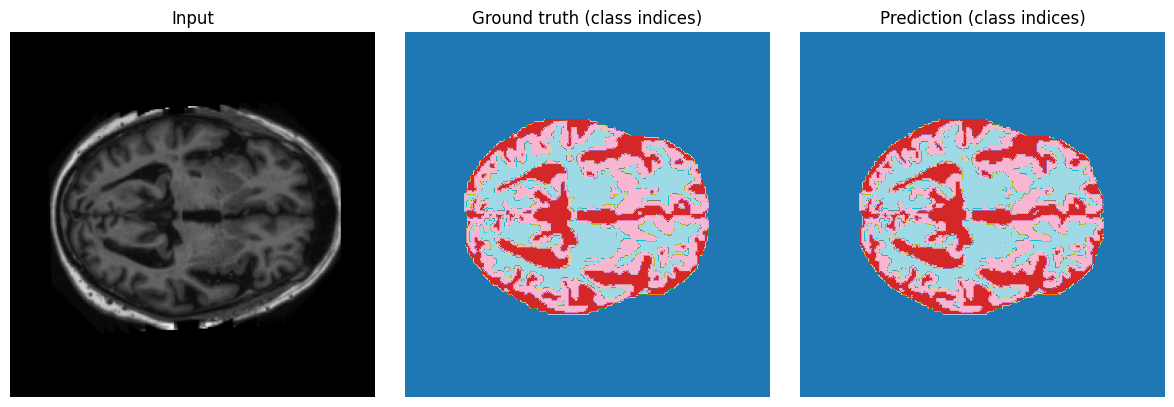

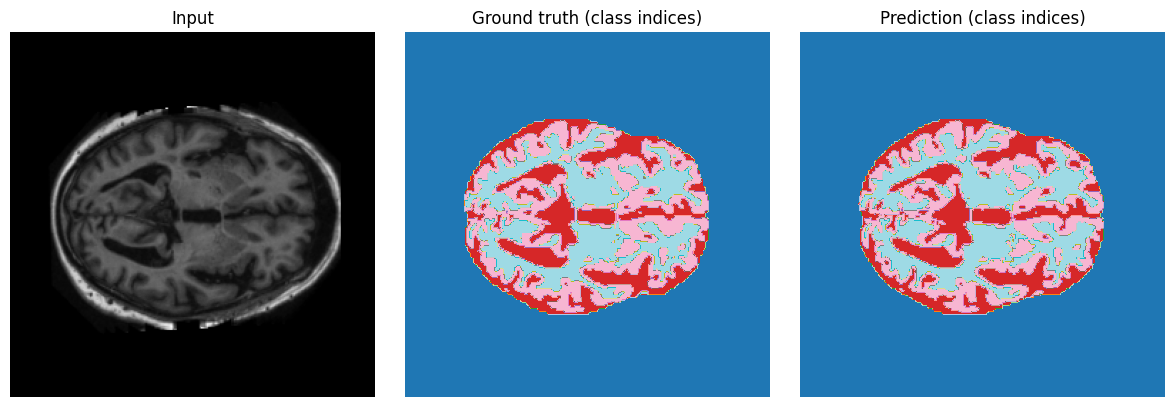

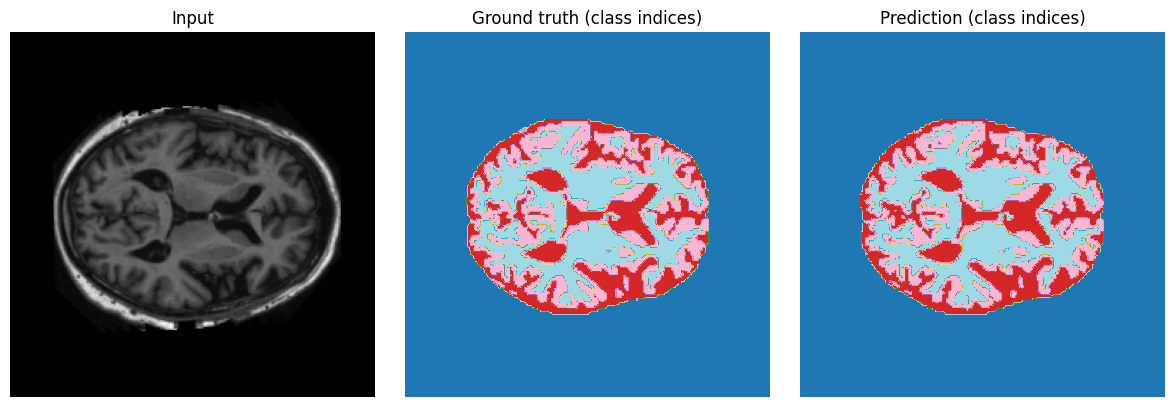

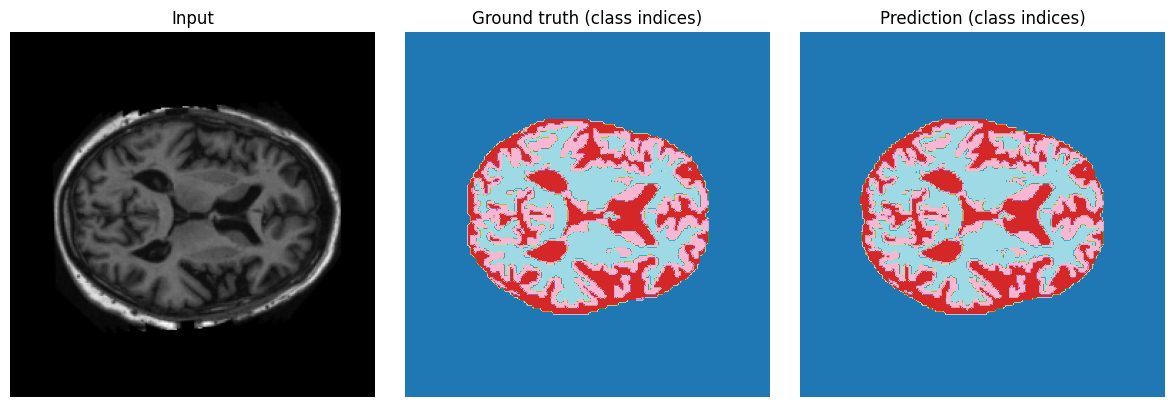

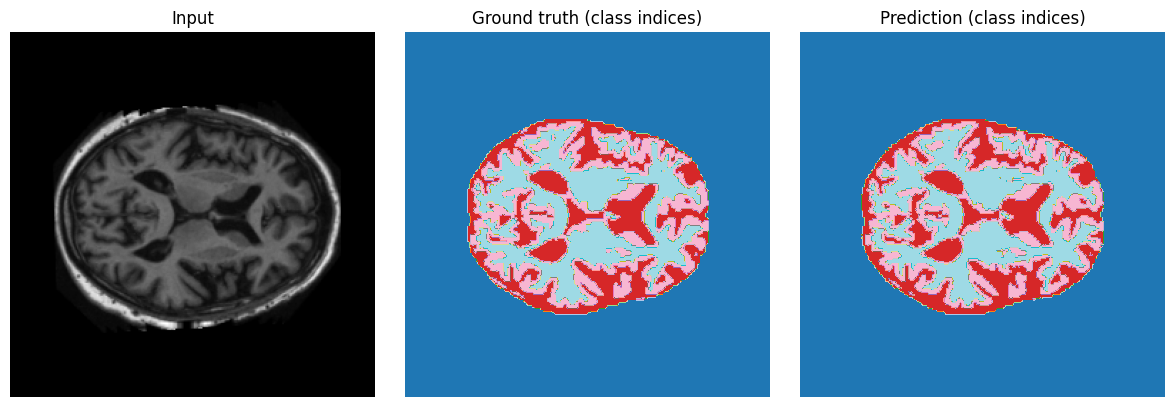

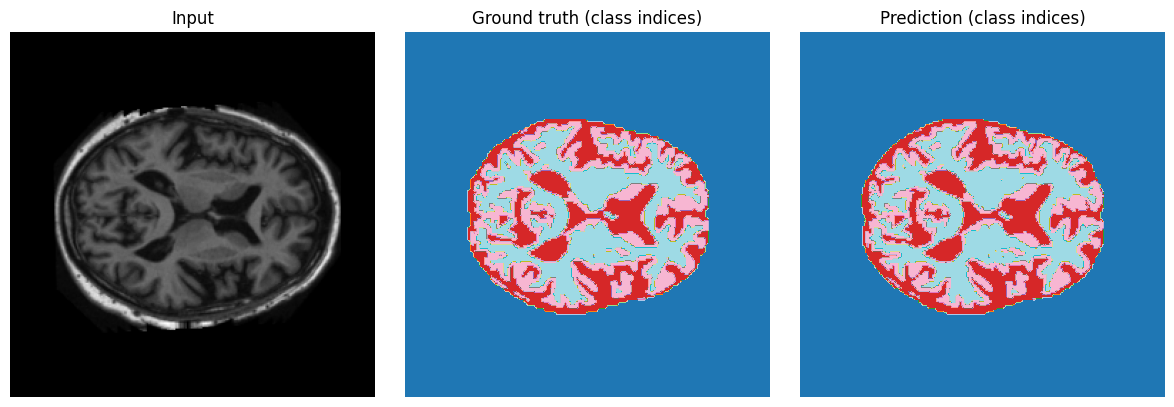

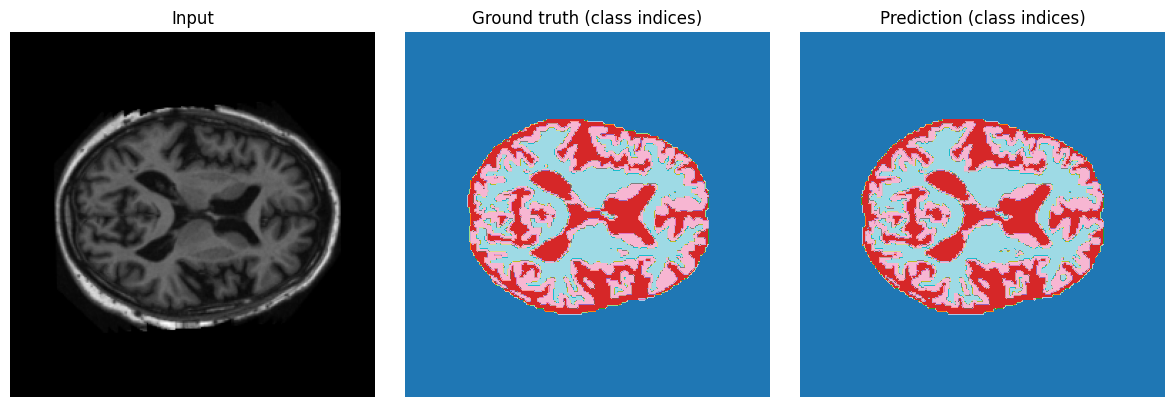

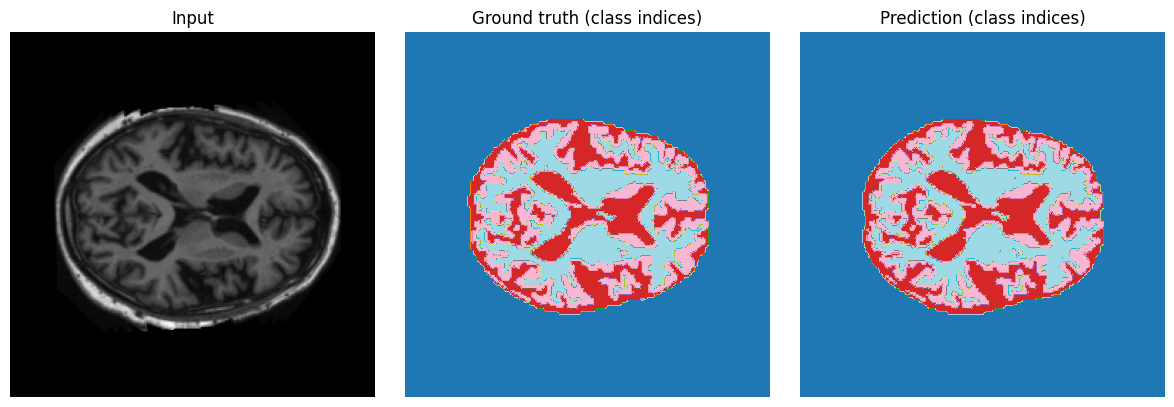

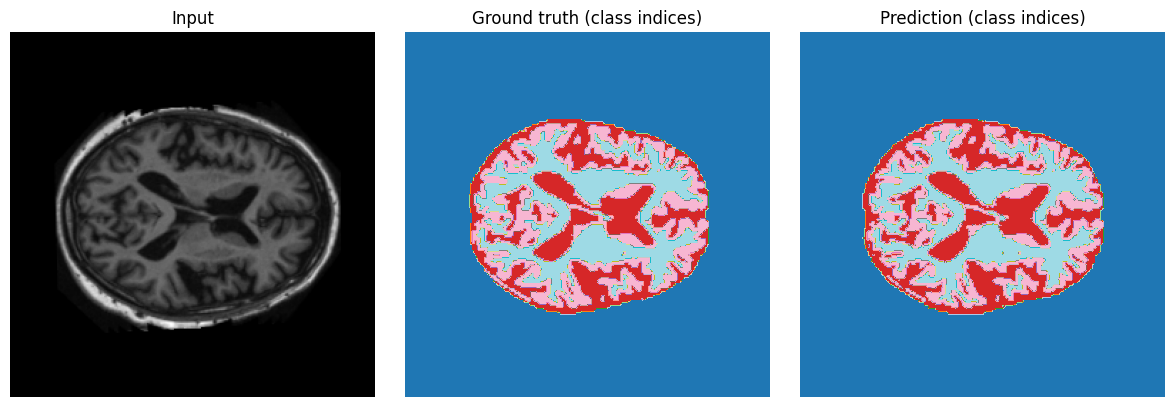

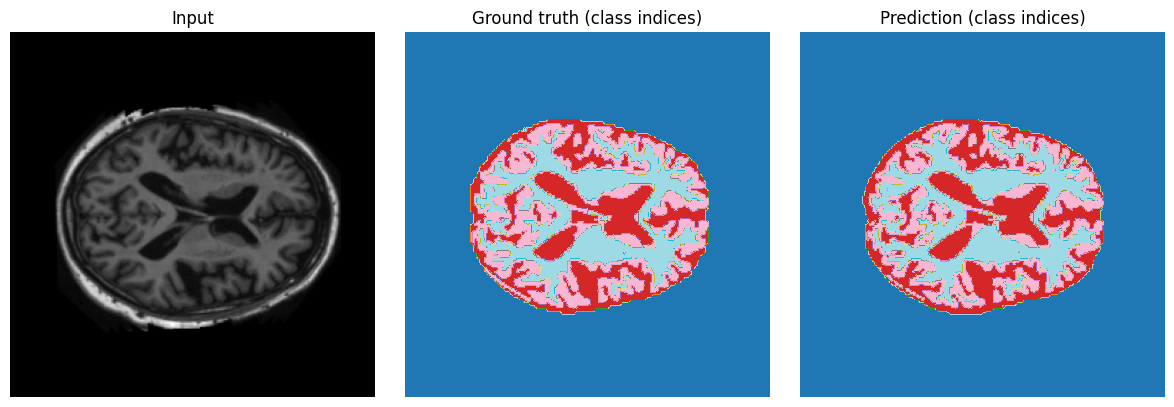

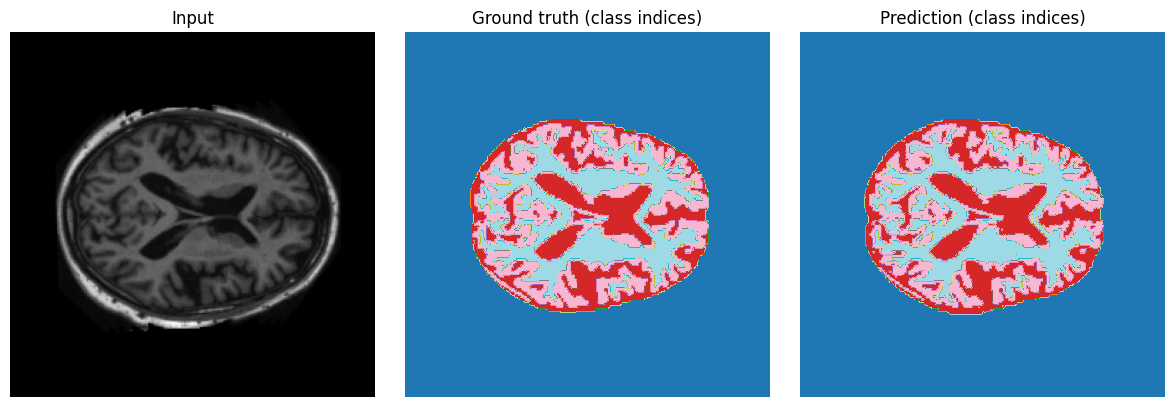

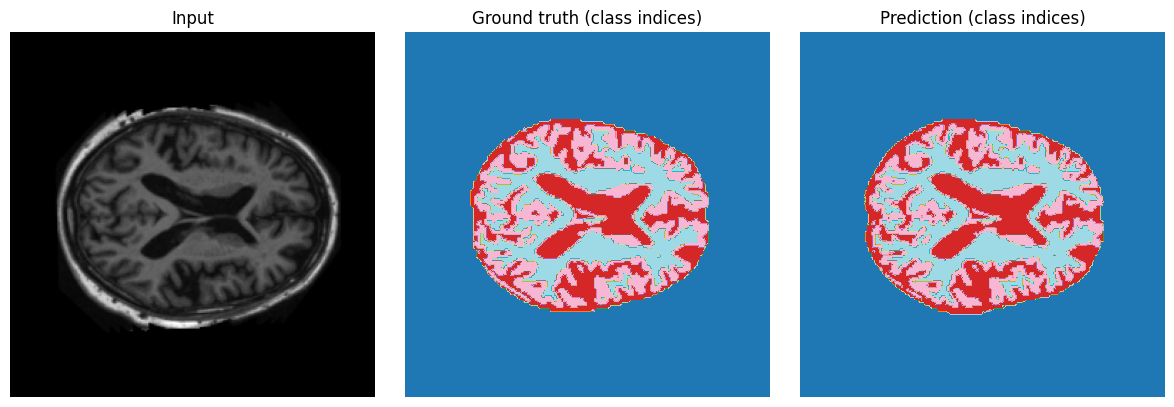

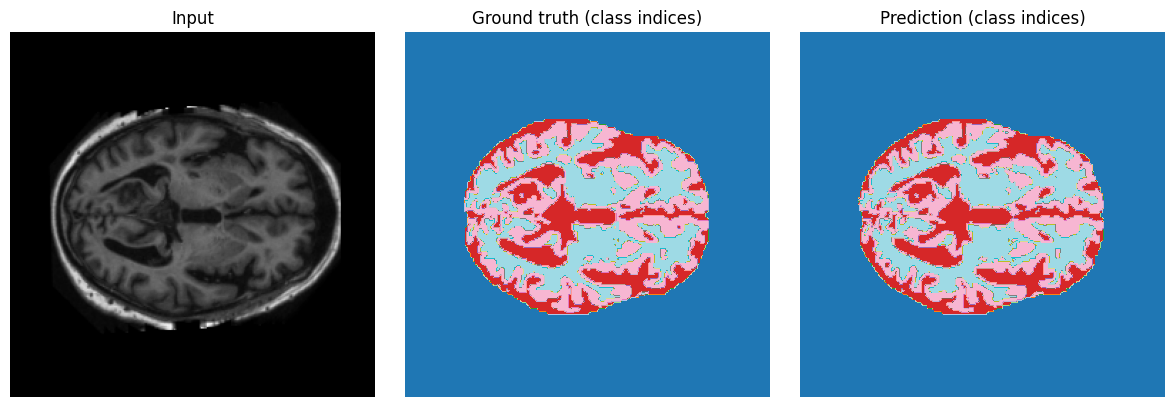

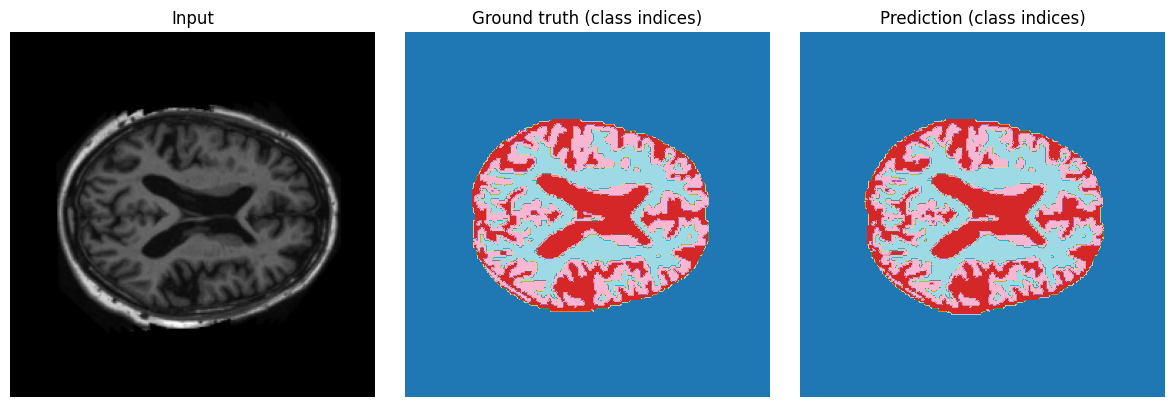

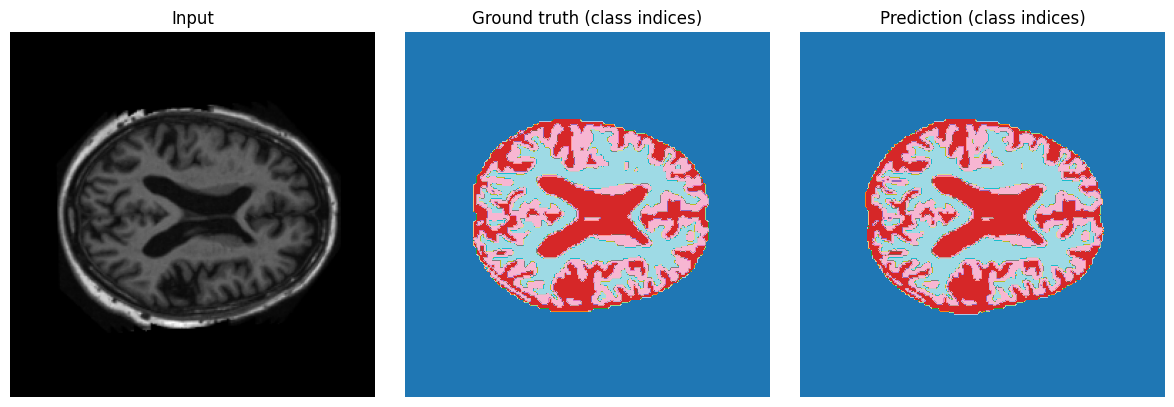

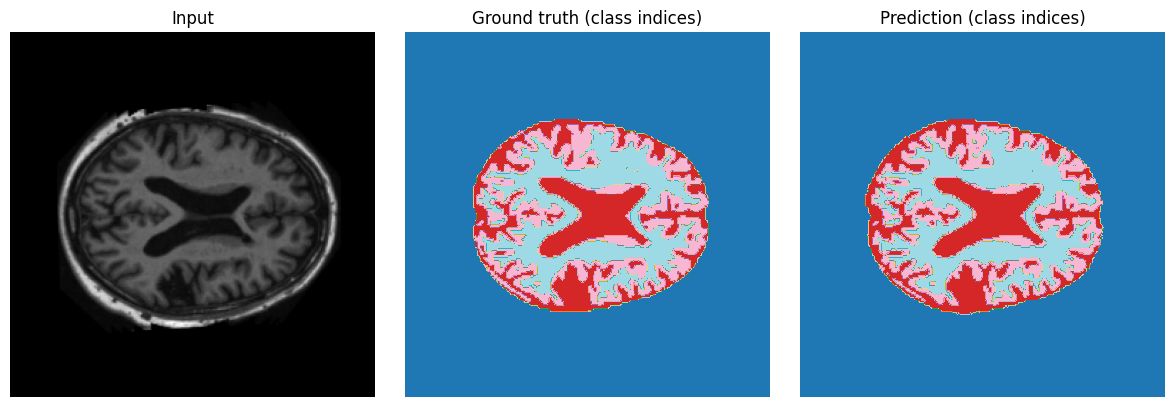

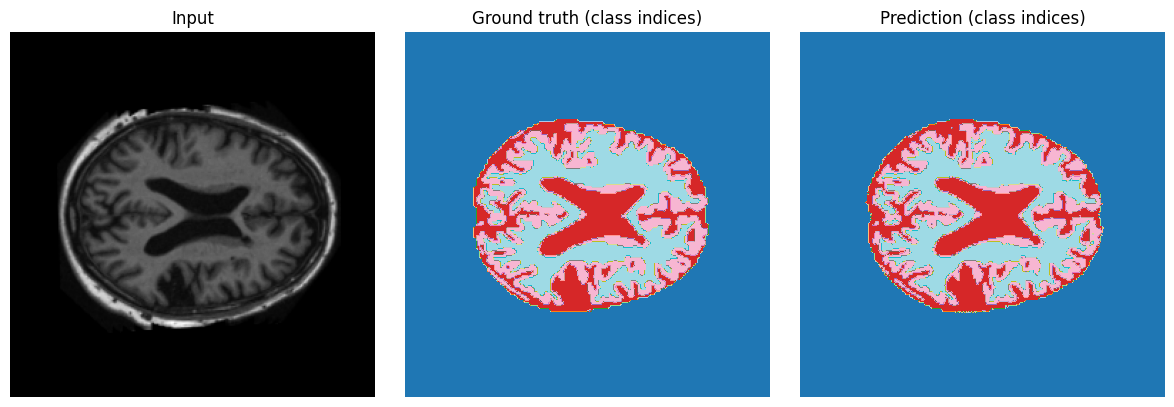

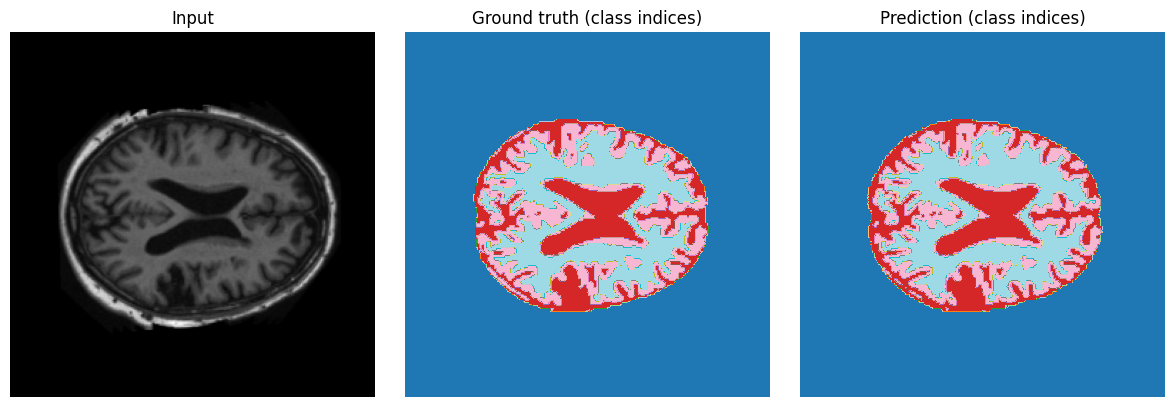

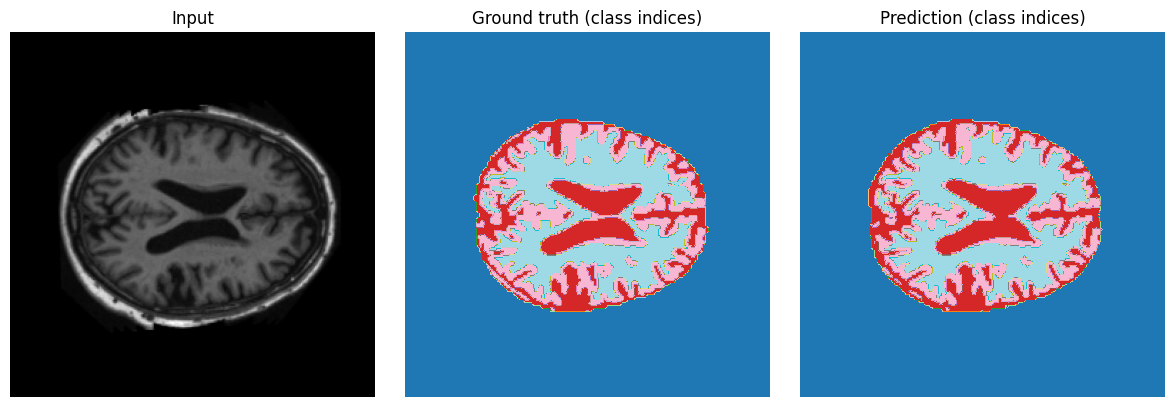

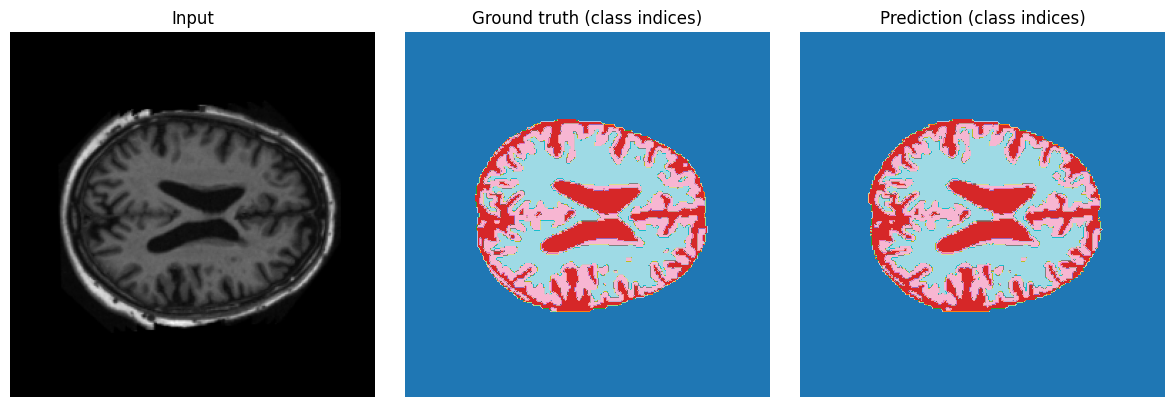

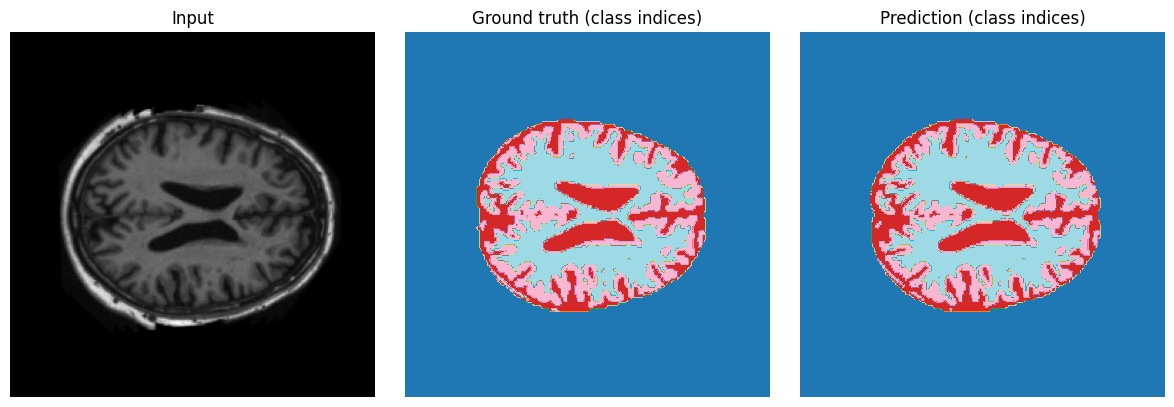

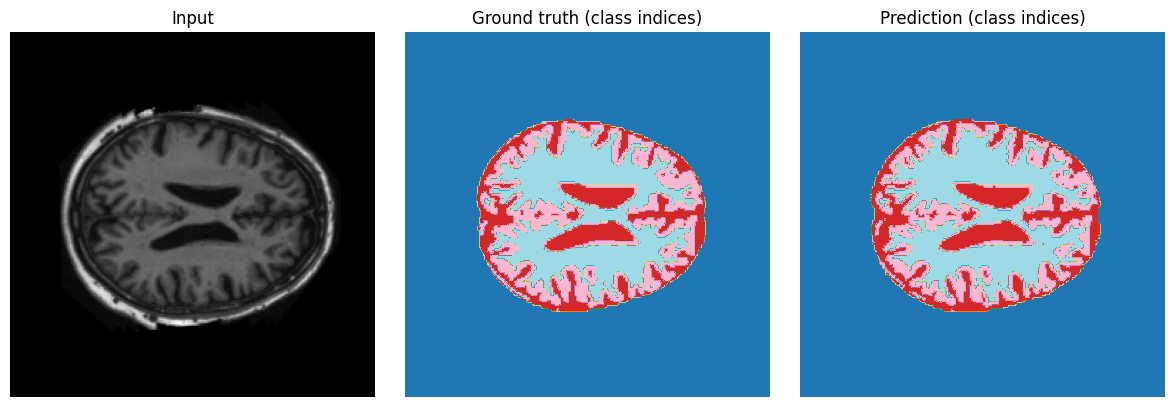

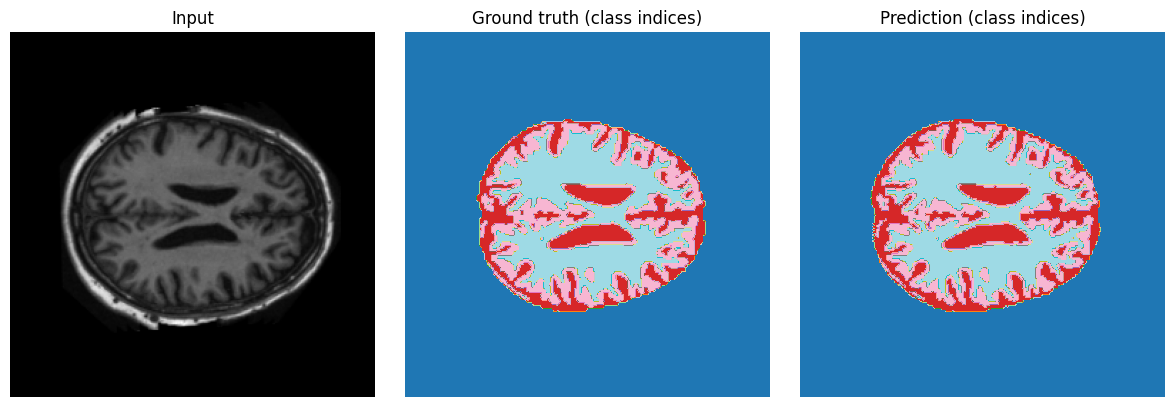

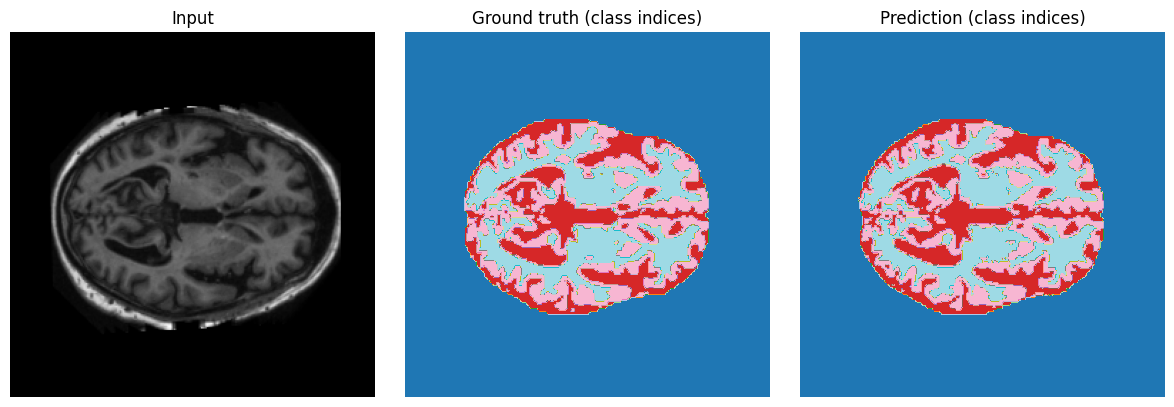

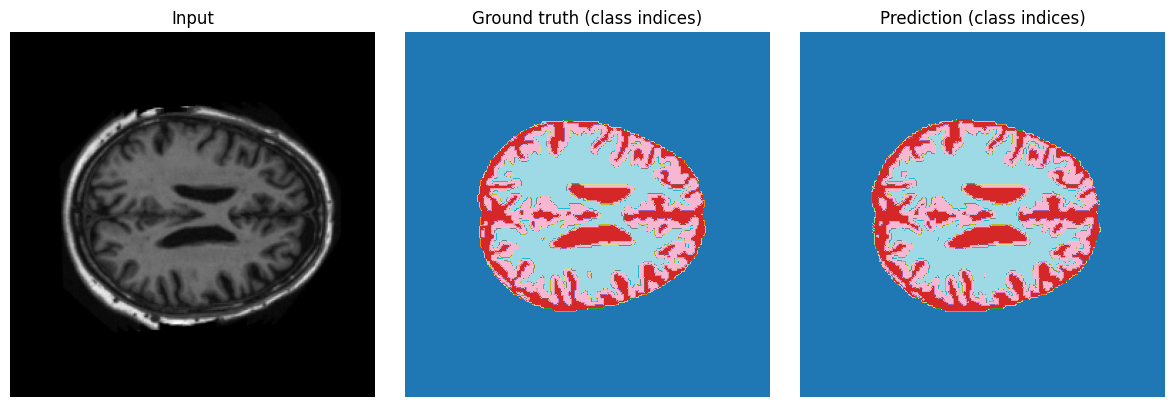

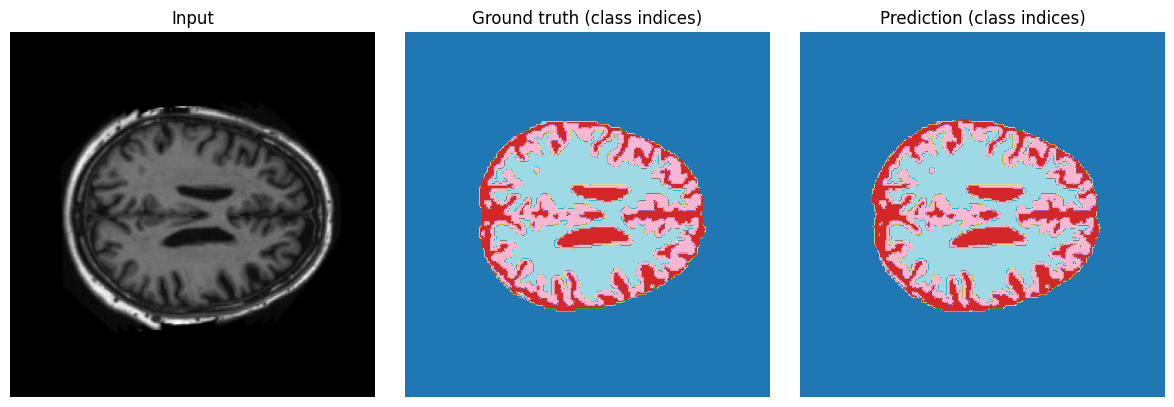

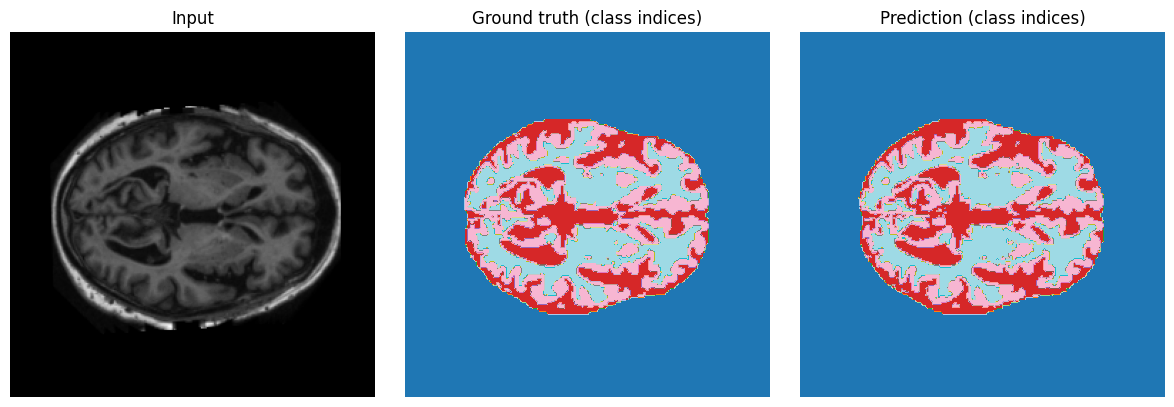

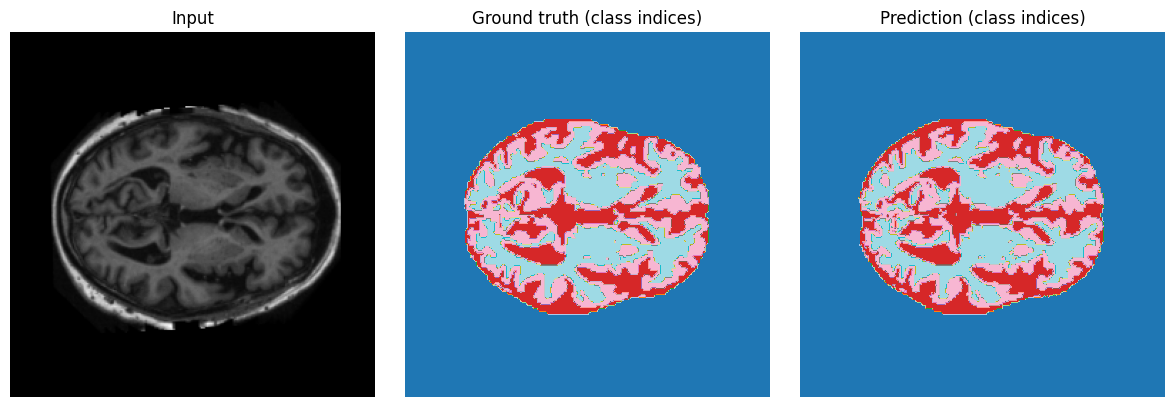

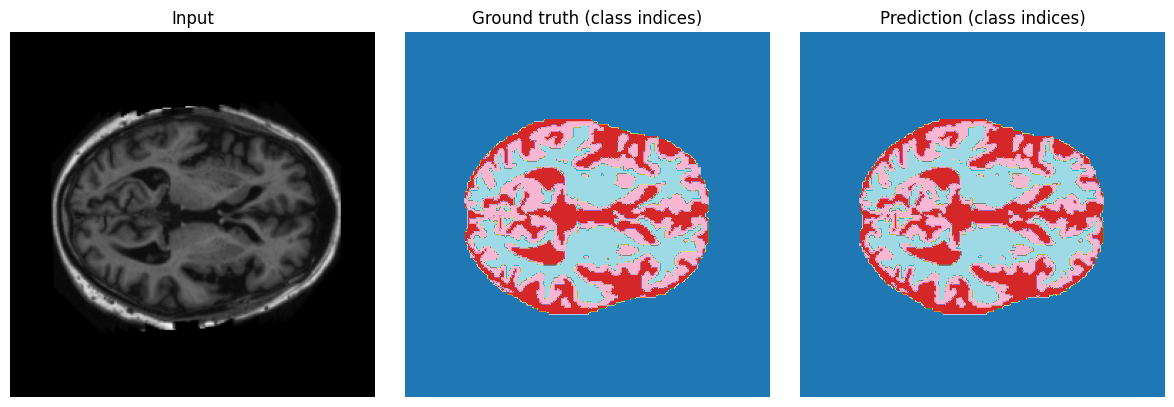

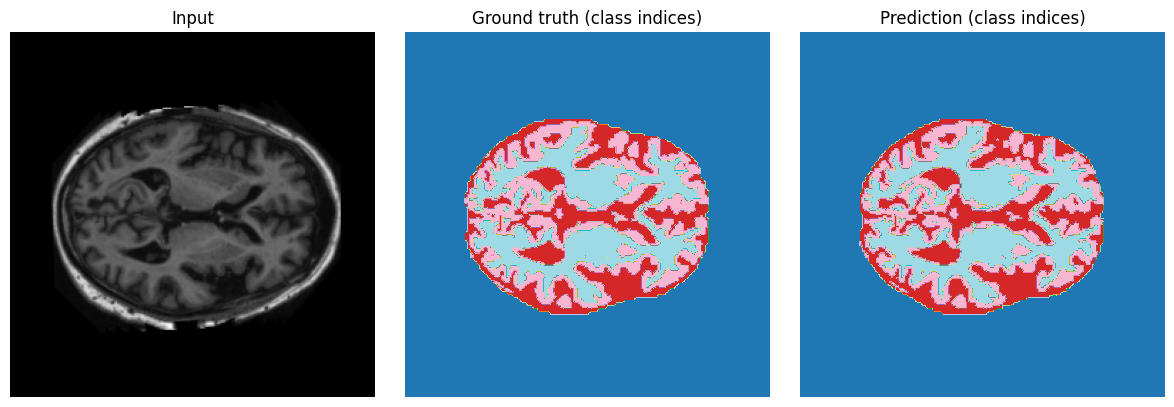

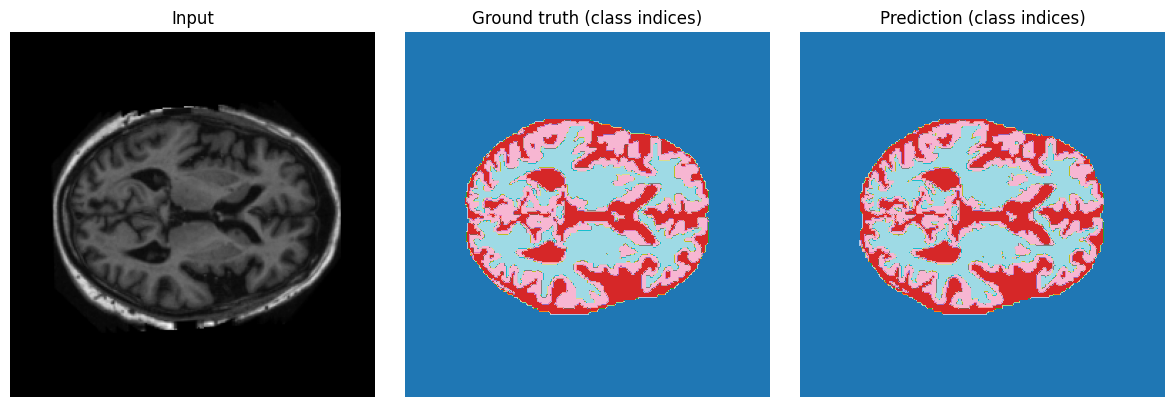

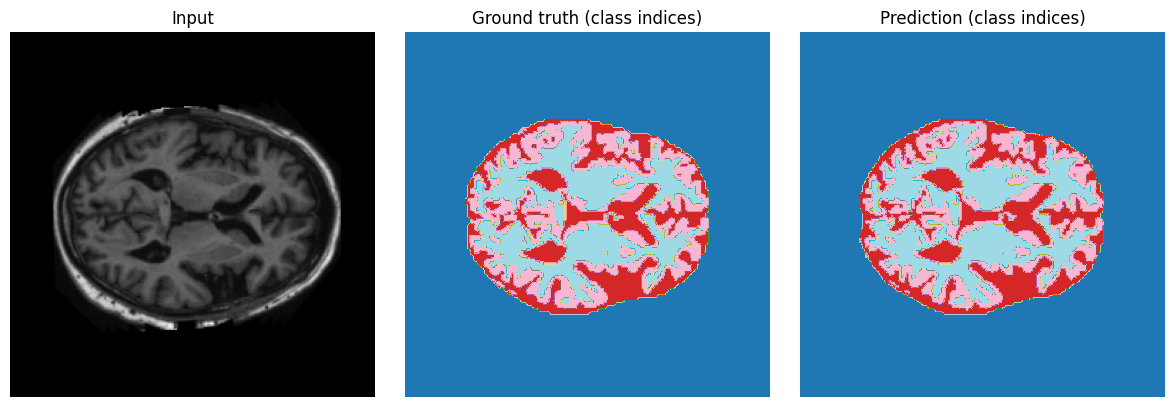

In [13]:
# Hyperparameters you can tune
N_CLASSES = 4
INPUT_CHANNELS = 1
BASE_FILTERS = 32
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 16
DICE_WEIGHT = 1.0
TARGET_MEAN_DICE = 0.94  # early stop target if you want

# Create model
unet = UNet(n_classes=N_CLASSES, input_channels=INPUT_CHANNELS, base_filters=BASE_FILTERS).to(device)

# If your train_loader/test_loader created earlier have different batch sizes or are named differently,
# replace them appropriately below.
# Here we reuse train_loader and test_loader from your earlier setup.
# If you want a validation split, create a valid_loader. For simplicity we'll use test_loader as val_loader.
val_loader = test_loader

# Train
trained_model, best_dice, best_epoch = train_unet(
    unet,
    train_loader,
    val_loader,
    n_classes=N_CLASSES,
    device=device,
    epochs=EPOCHS,
    lr=LR,
    dice_weight=DICE_WEIGHT,
    target_mean_dice=TARGET_MEAN_DICE,
    checkpoint_path=None #"unet_best.pth"
)

# Evaluate final model on test set and print per-class dice
per_class_dice, mean_dice = evaluate_model(trained_model, val_loader, n_classes=N_CLASSES, device=device)
print("Per-class DSC:", per_class_dice)
print("Mean DSC:", mean_dice)

# Visualise sample segmentations
visualize_segmentations(trained_model, val_loader, n_classes=N_CLASSES, device=device, num_batches=2) #, save_dir="seg_results")

# Optionally load best checkpoint later
# ckpt = torch.load("unet_best.pth", map_location=device)
# unet.load_state_dict(ckpt['model_state_dict'])
# print("Loaded checkpoint with val_mean_dice =", ckpt['val_mean_dice'])
